In [ ]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

import torch
from braindecode.models import EEGNetv4
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP

In [2]:
def create_csp_svm_pipeline(n_components=6):
	"""创建一个包含CSP和SVM的Scikit-learn管道"""
	return Pipeline([
		('csp', CSP(n_components=n_components, reg=None, log=True, norm_trace=False)),
		('svm', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True))
	])

In [3]:
def create_csp_lda_pipeline(n_components=6):
	"""创建一个包含CSP和LDA的管道"""
	return Pipeline([
		('csp', CSP(n_components=n_components, reg=None, log=True, norm_trace=False)),
		('lda', LinearDiscriminantAnalysis()) # 将SVC替换为LDA
	])

In [ ]:
def evaluate_eegnet_model(X_train, X_test, y_train, y_test, learning_rate=0.001,batch_size=16, n_epochs=1500):
	"""
	使用PyTorch训练并评估EEGNet模型。
	"""
	# ---检查GPU并定义超参数 ---
	cuda = torch.cuda.is_available()
	device = torch.device('cuda' if cuda else 'cpu')

	# # --- 数据准备 ---
	# 数据输入的时候已经做了归一化，就不需要再转换单位了
	# X_microvolts = X * 1e6
	# X_reshaped = X_microvolts[..., np.newaxis]
	# X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
	#   X_reshaped, y, test_size=0.2, random_state=42, stratify=y
	# )
	X_train_np = X_train[..., np.newaxis]
	X_test_np = X_test[..., np.newaxis]
	
	
	# 将训练数据转换为PyTorch TensorDataset
	X_train = torch.from_numpy(X_train_np).float()
	y_train = torch.from_numpy(y_train).long()
	train_dataset = TensorDataset(X_train, y_train)
	train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

	# 将测试数据转换为PyTorch Tensors
	X_test = torch.from_numpy(X_test_np).float().to(device)
	y_test = torch.from_numpy(y_test).long().to(device)

	# ---模型、损失函数、优化器定义 ---
	n_channels = X_train_np.shape[1]
	n_samples = X_train_np.shape[2]
	n_classes = len(np.unique(y_train))
	
	# 使用标准的EEGNet
	model = EEGNetv4(n_chans=n_channels, n_outputs=n_classes, n_times=n_samples, final_conv_length='auto').to(device)
	criterion = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

	# --- 训练循环 ---
	for epoch in range(n_epochs):
		model.train() # 将模型设置为训练模式
		for X_batch, y_batch in train_loader:
			X_batch, y_batch = X_batch.to(device), y_batch.to(device)
			
			optimizer.zero_grad()      # 1. 清空梯度
			outputs = model(X_batch)   # 2. 前向传播
			loss = criterion(outputs, y_batch) # 3. 计算损失
			loss.backward()            # 4. 反向传播
			optimizer.step()           # 5. 更新权重

		# # 测试性评估
		# if (epoch+1) % 100 == 0:
		# 	model.eval()
		# 	outputs_temp = model(X_test)
		# 	loss = criterion(outputs_temp, y_test)
		# 	_, y_pred_temp = torch.max(outputs_temp, 1)
		# 	accuracy = accuracy_score(y_test.cpu().numpy(), y_pred_temp.cpu().numpy())
		# 	print(f"accuracy: {accuracy}")
		# 	print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}")

	# --- 评估 ---
	model.eval() # 将模型设置为评估模式
	with torch.no_grad():
		test_outputs = model(X_test)
		_, y_pred = torch.max(test_outputs, 1)
	
	# 将GPU上的Tensor转回CPU上的Numpy数组以进行评估
	y_pred_np = y_pred.cpu().numpy()
	y_test_np = y_test.cpu().numpy()

	print(f'y_val: {y_test_np}')
	print(f'v_val: {y_pred}')
	accuracy = accuracy_score(y_test_np, y_pred_np)
	report = classification_report(y_test_np, y_pred_np, target_names=['Left Hand', 'Right Hand'], zero_division=0)
	
	return accuracy, report

In [5]:
def evaluate_model_for_subject(X_train, X_test, y_train, y_test, model_pipeline):
	"""
	在模型上进行训练和评估
	返回总体准确率和详细的分类报告。
	"""
	
	# 在训练集上拟合模型
	model_pipeline.fit(X_train, y_train)
	
	# 在测试集上进行预测
	y_pred = model_pipeline.predict(X_test)
	
	# 评估结果
	accuracy = accuracy_score(y_test, y_pred)
	report = classification_report(y_test, y_pred, target_names=['Left Hand', 'Right Hand'], zero_division=0)
	
	return accuracy, report

共找到 125 个待处理文件。

--- 正在评估被试: sub-001_ses-01 ---
Computing rank from data with rank=None
    Using tolerance 6.9 (2.2e-16 eps * 32 dim * 9.7e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.8000
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.71      1.00      0.83        10
  Right Hand       1.00      0.60      0.75        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20

----------------------------------------
--- 正在评估被试: sub-001_ses-02 ---
Computing rank from data with rank=None
    Using tolerance 5.7 (2.2e-16 eps * 32 dim * 8e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 dat

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\16040

    Using tolerance 6.7 (2.2e-16 eps * 32 dim * 9.4e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.4211
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.46      0.60      0.52        10
  Right Hand       0.33      0.22      0.27         9

    accuracy                           0.42        19
   macro avg       0.40      0.41      0.39        19
weighted avg       0.40      0.42      0.40        19

----------------------------------------
--- 正在评估被试: sub-003_ses-05 ---
Computing rank from data with rank=None
    Using tolerance 8.8 (2.2e-16 eps * 32 dim * 1.2e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covar

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


Computing rank from data with rank=None
    Using tolerance 2.2 (2.2e-16 eps * 32 dim * 3.1e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.6667
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.67      1.00      0.80         2
  Right Hand       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

----------------------------------------
--- 正在评估被试: sub-004_ses-04 ---
Computing rank from data with rank=None
    Using tolerance 5.9 (2.2e-16 eps * 32 dim * 8.2e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data ran

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\16040

Computing rank from data with rank=None
    Using tolerance 6.3 (2.2e-16 eps * 32 dim * 8.9e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.7500
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.73      0.80      0.76        10
  Right Hand       0.78      0.70      0.74        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20

----------------------------------------
--- 正在评估被试: sub-007_ses-02 ---
Computing rank from data with rank=None
    Using tolerance 6 (2.2e-16 eps * 32 dim * 8.4e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank 

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\16040

Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.4444
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.43      0.33      0.38         9
  Right Hand       0.45      0.56      0.50         9

    accuracy                           0.44        18
   macro avg       0.44      0.44      0.44        18
weighted avg       0.44      0.44      0.44        18

----------------------------------------
--- 正在评估被试: sub-008_ses-05 ---
Computing rank from data with rank=None
    Using tolerance 7.7 (2.2e-16 eps * 32 dim * 1.1e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.7000
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.64      0.90      0.75        10

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.3500
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.33      0.30      0.32        10
  Right Hand       0.36      0.40      0.38        10

    accuracy                           0.35        20
   macro avg       0.35      0.35      0.35        20
weighted avg       0.35      0.35      0.35        20

----------------------------------------
--- 正在评估被试: sub-009_ses-03 ---
Computing rank from data with rank=None
    Using tolerance 8.7 (2.2e-16 eps * 32 dim * 1.2e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Don

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\16040

Computing rank from data with rank=None
    Using tolerance 7.8 (2.2e-16 eps * 32 dim * 1.1e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.8235
分类报告:
               precision    recall  f1-score   support

   Left Hand       1.00      0.62      0.77         8
  Right Hand       0.75      1.00      0.86         9

    accuracy                           0.82        17
   macro avg       0.88      0.81      0.81        17
weighted avg       0.87      0.82      0.82        17

----------------------------------------
--- 正在评估被试: sub-010_ses-05 ---
!!!!!! 跳过文件: 只剩下 0 个类别，无法进行二分类。!!!!!!
----------------------------------------
--- 正在评估被试: sub-011_ses-01 ---
Computing rank from data with rank=None
    Using tolerance 8.8 (2.2e-16 eps * 32 dim * 1.2e+15  max singular value)


C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.3000
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.30      0.30      0.30        10
  Right Hand       0.30      0.30      0.30        10

    accuracy                           0.30        20
   macro avg       0.30      0.30      0.30        20
weighted avg       0.30      0.30      0.30        20

----------------------------------------
--- 正在评估被试: sub-011_ses-02 ---
!!!!!! 跳过文件: 只剩下 0 个类别，无法进行二分类。!!!!!!
----------------------------------------
--- 正在评估被试: sub-011_ses-03 ---
Computing rank from data with rank=None
    Using tolerance 4.4 (2.2e-16 eps * 32 dim * 6.2e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


    Using tolerance 6.4 (2.2e-16 eps * 32 dim * 9.1e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.3636
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.40      0.33      0.36         6
  Right Hand       0.33      0.40      0.36         5

    accuracy                           0.36        11
   macro avg       0.37      0.37      0.36        11
weighted avg       0.37      0.36      0.36        11

----------------------------------------
--- 正在评估被试: sub-011_ses-05 ---
Computing rank from data with rank=None
    Using tolerance 8.1 (2.2e-16 eps * 32 dim * 1.1e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covar

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\16040

Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.8462
分类报告:
               precision    recall  f1-score   support

   Left Hand       1.00      0.67      0.80         6
  Right Hand       0.78      1.00      0.88         7

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13

----------------------------------------
--- 正在评估被试: sub-013_ses-02 ---
Computing rank from data with rank=None
    Using tolerance 6.6 (2.2e-16 eps * 32 dim * 9.2e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.5294
分类报告:
               precision    recall  f1-score   support

   Left Hand       0

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\16040

准确率: 0.7273
分类报告:
               precision    recall  f1-score   support

   Left Hand       1.00      0.50      0.67         6
  Right Hand       0.62      1.00      0.77         5

    accuracy                           0.73        11
   macro avg       0.81      0.75      0.72        11
weighted avg       0.83      0.73      0.71        11

----------------------------------------
--- 正在评估被试: sub-016_ses-02 ---
Computing rank from data with rank=None
    Using tolerance 7.3 (2.2e-16 eps * 32 dim * 1e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.7778
分类报告:
               precision    recall  f1-score   support

   Left Hand       1.00      0.56      0.71         9
  Right Hand       0.69      1.00      0.82         9

    accuracy                           0.78       

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


    Using tolerance 6.8 (2.2e-16 eps * 32 dim * 9.6e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.9000
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.83      1.00      0.91        10
  Right Hand       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

----------------------------------------
--- 正在评估被试: sub-017_ses-02 ---
Computing rank from data with rank=None
    Using tolerance 9.6 (2.2e-16 eps * 32 dim * 1.4e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covar

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


准确率: 0.7273
分类报告:
               precision    recall  f1-score   support

   Left Hand       1.00      0.50      0.67         6
  Right Hand       0.62      1.00      0.77         5

    accuracy                           0.73        11
   macro avg       0.81      0.75      0.72        11
weighted avg       0.83      0.73      0.71        11

----------------------------------------
--- 正在评估被试: sub-017_ses-05 ---
Computing rank from data with rank=None
    Using tolerance 4.2 (2.2e-16 eps * 32 dim * 5.9e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.8333
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.67      1.00      0.80         2
  Right Hand       1.00      0.75      0.86         4

    accuracy                           0.83     

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


准确率: 0.8571
分类报告:
               precision    recall  f1-score   support

   Left Hand       1.00      0.71      0.83         7
  Right Hand       0.78      1.00      0.88         7

    accuracy                           0.86        14
   macro avg       0.89      0.86      0.85        14
weighted avg       0.89      0.86      0.85        14

----------------------------------------
--- 正在评估被试: sub-019_ses-03 ---
!!!!!! 跳过文件: 只剩下 0 个类别，无法进行二分类。!!!!!!
----------------------------------------
--- 正在评估被试: sub-019_ses-04 ---
Computing rank from data with rank=None
    Using tolerance 6.9 (2.2e-16 eps * 32 dim * 9.7e+14  max singular value)


C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.5789
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.57      0.44      0.50         9
  Right Hand       0.58      0.70      0.64        10

    accuracy                           0.58        19
   macro avg       0.58      0.57      0.57        19
weighted avg       0.58      0.58      0.57        19

----------------------------------------
--- 正在评估被试: sub-019_ses-05 ---
!!!!!! 跳过文件: 只剩下 0 个类别，无法进行二分类。!!!!!!
----------------------------------------
--- 正在评估被试: sub-020_ses-01 ---
Computing rank from data with rank=None
    Using tolerance 3.5 (2.2e-16 eps * 32 dim * 5e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


    Using tolerance 3.8 (2.2e-16 eps * 32 dim * 5.3e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.1667
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00         3
  Right Hand       0.25      0.33      0.29         3

    accuracy                           0.17         6
   macro avg       0.12      0.17      0.14         6
weighted avg       0.12      0.17      0.14         6

----------------------------------------
--- 正在评估被试: sub-020_ses-04 ---
Computing rank from data with rank=None
    Using tolerance 8.8 (2.2e-16 eps * 32 dim * 1.2e+15  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covar

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.7000
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.70      0.70      0.70        10
  Right Hand       0.70      0.70      0.70        10

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20

----------------------------------------
--- 正在评估被试: sub-022_ses-01 ---
Computing rank from data with rank=None
    Using tolerance 6.4 (2.2e-16 eps * 32 dim * 9e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.3333
分类报告:
           

C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_22584\1604082385.py:34: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)


准确率: 0.8000
分类报告:
               precision    recall  f1-score   support

   Left Hand       1.00      0.60      0.75         5
  Right Hand       0.71      1.00      0.83         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10

----------------------------------------
--- 正在评估被试: sub-023_ses-03 ---
Computing rank from data with rank=None
    Using tolerance 5.6 (2.2e-16 eps * 32 dim * 7.9e+14  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
准确率: 0.5833
分类报告:
               precision    recall  f1-score   support

   Left Hand       0.60      0.50      0.55         6
  Right Hand       0.57      0.67      0.62         6

    accuracy                           0.58     

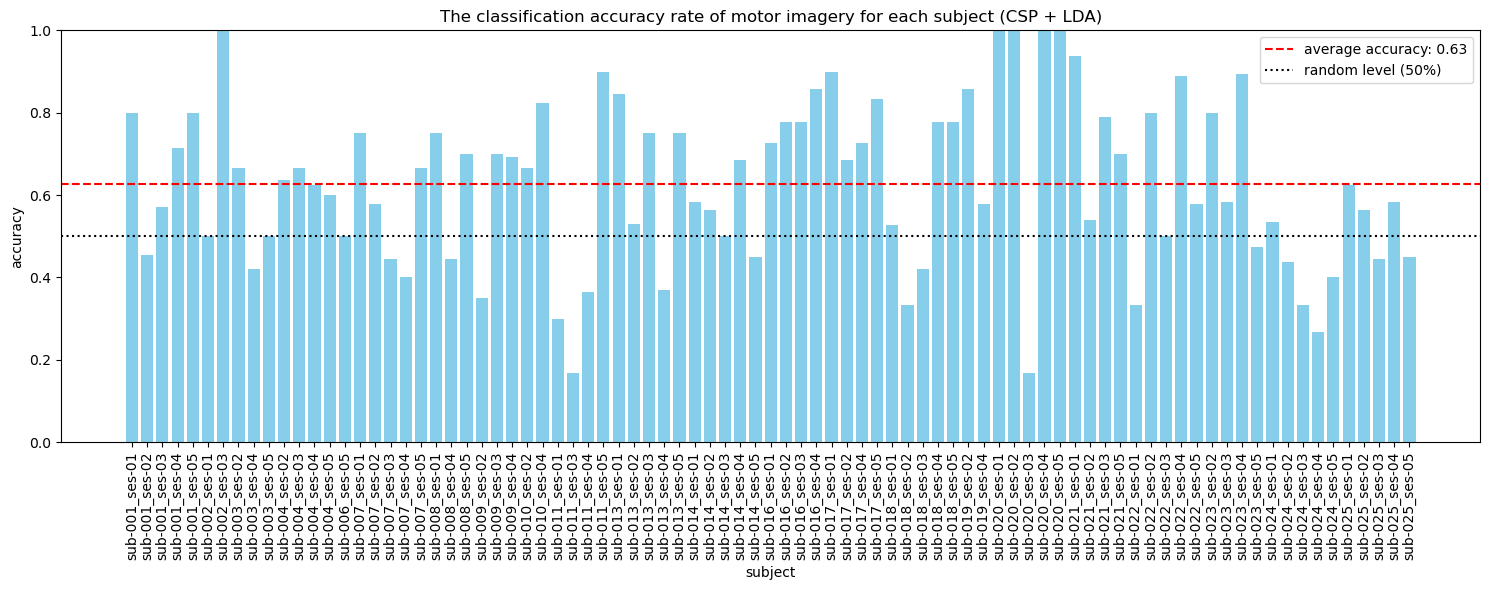

In [6]:
# 会话内、被试专属模型 (Within-Session, Subject-Specific) 范式

"""主执行函数"""
processed_dir = './data/all-processed/'
epoch_files = glob.glob(os.path.join(processed_dir, 'sub-*_ses-*_task_motorimagery_eeg-epo.fif'))
epoch_files.sort()

if not epoch_files:
	raise FileNotFoundError("在 processed_dir 中没有找到处理好的文件。")

print(f"共找到 {len(epoch_files)} 个待处理文件。\n")

all_subject_accuracies = []
all_subject_names = []

# 创建模型管道
# 只需要修改pipeline_name，就可以切换到不同的训练策略
#pipeline_name = "EEGNet"
#pipeline_name = "CSP + SVM"
pipeline_name = "CSP + LDA"
if pipeline_name == 'CSP + SVM':
	model_pipeline = create_csp_svm_pipeline()
elif pipeline_name == 'CSP + LDA':
	model_pipeline = create_csp_lda_pipeline()

valid_sample = 0 #

for file_path in epoch_files:
	subject_name = os.path.basename(file_path).split('_task')[0]
	print(f"--- 正在评估被试: {subject_name} ---")
	
	try:
		# 加载数据和标签
		epochs = mne.read_epochs(file_path, preload=True, verbose=False)
		label_path = file_path.replace('-epo.fif', '-labels.npy')
		labels_from_file = np.load(label_path)
		labels = (labels_from_file - 1).astype(np.int64)
		
		unique_labels, counts = np.unique(labels, return_counts=True)
				
		# 是否还剩下两个类别
		if len(unique_labels) < 2:
			print(f"!!!!!! 跳过文件: 只剩下 {len(unique_labels)} 个类别，无法进行二分类。!!!!!!")
			print("-" * 40)
			continue # 跳到下一个文件
		
		# 检查2：数量最少的类别，其样本数是否足够进行分割 (至少为2)
		if np.min(counts) < 2:
			print(f"!!!!!! 跳过文件: 数量最少的类别只有 {np.min(counts)} 个样本，无法进行有效的训练/测试集分割。!!!!!!")
			print("-" * 40)
			continue

		# 提取并确保数据类型正确
		X = epochs.get_data().astype('float64')
		y = labels

		# 将数据分割成训练集和测试集 (80% 训练, 20% 测试)
		# stratify=y 确保训练集和测试集中，左右手的标签比例与原始数据一致
		X_train, X_test, y_train, y_test = train_test_split(
			X, y, test_size=0.2, random_state=42, stratify=y
		)

		# 计算所有训练数据点的均值和标准差，进行归一化; 不使用验证集的东西，避免信息泄露
		mean = X_train.mean()
		std = X_train.std()
		std = std if std != 0 else 1e-8 # 避免分母为0

		X_train_norm = (X_train - mean) / std
		X_test_norm = (X_test - mean) / std


		# 调用评估函数
		if pipeline_name == 'EEGNet':
			accuracy, report = evaluate_eegnet_model(X_train_norm, X_test_norm, y_train, y_test, learning_rate=0.001, batch_size=16, n_epochs=1500)
		else:
			accuracy, report = evaluate_model_for_subject(X_train_norm, X_test_norm, y_train, y_test, model_pipeline)
		
		# 打印和记录结果
		print(f"准确率: {accuracy:.4f}")
		print("分类报告:\n", report) # 可以选择性地取消注释以查看每个被试的详细报告
		
		all_subject_accuracies.append(accuracy)
		all_subject_names.append(subject_name)

	except Exception as e:
		print(f"!!!!!! 处理文件 {subject_name} 时发生严重错误: {e} !!!!!!")
	print("-" * 40)
		
# --- 汇总并可视化结果 ---
if all_subject_accuracies:
	mean_accuracy = np.mean(all_subject_accuracies)
	std_accuracy = np.std(all_subject_accuracies)

	print("\n" + "="*50)
	print(f"所有被试的平均分类准确率: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
	print("="*50)

	# 绘制结果图 
	plt.figure(figsize=(15, 6))
	plt.bar(all_subject_names, all_subject_accuracies, color='skyblue')
	plt.axhline(mean_accuracy, color='red', linestyle='--', label=f'average accuracy: {mean_accuracy:.2f}')
	plt.axhline(0.5, color='black', linestyle=':', label='random level (50%)')
	plt.title(f'The classification accuracy rate of motor imagery for each subject ({pipeline_name})')
	plt.ylabel('accuracy')
	plt.xlabel('subject')
	plt.xticks(rotation=90)
	plt.ylim([0, 1])
	plt.legend()
	plt.tight_layout()
	plt.show()

## 另一方面

**接下来在跨被试跨会话的背景下做一些测试**

因为前面的代码是对于会话内设计的，所以这里要稍微更改一点点

In [6]:
# 辅助函数：专门用于加载和合并一个目录下的所有数据
def load_all_data_from_directory(directory_path):
    """
    加载一个目录下所有处理好的.fif和.npy文件，并合并成一个大的数据集。
    """
    all_X = []
    all_y = []
    
    file_paths = glob.glob(os.path.join(directory_path, 'sub-*-epo.fif'))
    file_paths.sort()

    if not file_paths:
        raise FileNotFoundError(f"在目录 {directory_path} 中没有找到处理好的 -epo.fif 文件。")
        
    print(f"正在从 {directory_path} 加载 {len(file_paths)} 个文件...")
    for file_path in file_paths:
        epochs = mne.read_epochs(file_path, preload=True, verbose=False)
        
        # 跳过因预处理而变空的文件
        if len(epochs) == 0:
            continue
            
        labels_from_file = np.load(file_path.replace('-epo.fif', '-labels.npy'))
        labels = (labels_from_file - 1).astype(np.int64)
        
        all_X.append(epochs.get_data().astype('float64'))
        all_y.append(labels) # 标签在预处理时已是int64
        
    # 将所有数据和标签合并成一个大的Numpy数组
    X_combined = np.concatenate(all_X, axis=0)
    y_combined = np.concatenate(all_y, axis=0)
    
    return X_combined, y_combined

In [7]:
#(跨被试/会话 )


"""主执行函数 (跨被试/会话版)"""
try:
	# 定义路径
	train_dir = './data/train-processed/'
	val_dir = './data/val-processed/' 

	# **修改pipeline_name就可以切换训练策略**
	pipeline_name = "EEGNet"
	#pipeline_name = 'CSP + SVM'
	#pipeline_name = 'CSP + LDA'
	if pipeline_name == 'CSP + SVM':
		model_pipeline = create_csp_svm_pipeline()
	elif pipeline_name == 'CSP + LDA':
		model_pipeline = create_csp_lda_pipeline()
	elif pipeline_name != 'EEGNet':
		raise Exception("pipeline_name error")

	
	# 加载全部训练数据和验证数据
	X_train_all, y_train_all = load_all_data_from_directory(train_dir)
	print(f"训练集加载完成。总共 {len(y_train_all)} 个 trials。")
	X_val_all, y_val_all = load_all_data_from_directory(val_dir)
	print(f"验证集加载完成。总共 {len(y_val_all)} 个 trials。\n")

	# 计算所有训练数据点的均值和标准差，进行归一化; 不使用验证集的东西，避免信息泄露
	mean = X_train_all.mean()
	std = X_train_all.std()
	std = std if std != 0 else 1e-8 # 避免分母为0

	X_train_all_norm = (X_train_all - mean) / std
	X_val_all_norm = (X_val_all - mean) / std

	# 调用我们升级后的评估函数，并传入独立的测试集

	print(f"--- 开始执行最终的跨被试评估 ({pipeline_name}) ---")
	if pipeline_name == 'EEGNet':
		accuracy, report = evaluate_eegnet_model(X_train_all_norm, X_val_all_norm, y_train_all, y_val_all, learning_rate=0.0001, batch_size=16, n_epochs=1500)
	else:
		accuracy, report = evaluate_model_for_subject(X_train_all_norm, X_val_all_norm, y_train_all, y_val_all, model_pipeline)
	
	# 打印最终结果
	print("\n" + "="*50)
	print(f"跨被试/跨会话模型的最终准确率: {accuracy:.4f}")
	print("="*50)
	print("最终分类报告:\n", report)

except Exception as e:
	print(f"!!!!!! 主程序执行时发生严重错误: {e} !!!!!!")




正在从 ./data/train-processed/ 加载 100 个文件...


C:\Users\16155\AppData\Local\Temp\ipykernel_9192\1405636970.py:17: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_9192\1405636970.py:17: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_9192\1405636970.py:17: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_9192\140563697

训练集加载完成。总共 4116 个 trials。
正在从 ./data/val-processed/ 加载 25 个文件...


C:\Users\16155\AppData\Local\Temp\ipykernel_9192\1405636970.py:17: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_9192\1405636970.py:17: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_9192\1405636970.py:17: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  epochs = mne.read_epochs(file_path, preload=True, verbose=False)
C:\Users\16155\AppData\Local\Temp\ipykernel_9192\140563697

验证集加载完成。总共 1830 个 trials。

--- 开始执行最终的跨被试评估 (EEGNet) ---
Epoch [100/1500], Loss: 0.263182
Epoch [200/1500], Loss: 1.162895
Epoch [300/1500], Loss: 0.195748
Epoch [400/1500], Loss: 0.909871
Epoch [500/1500], Loss: 0.422428
Epoch [600/1500], Loss: 1.076103
Epoch [700/1500], Loss: 0.461258
Epoch [800/1500], Loss: 0.475082
Epoch [900/1500], Loss: 0.393079
Epoch [1000/1500], Loss: 0.240355
Epoch [1100/1500], Loss: 0.111430
Epoch [1200/1500], Loss: 0.884996
Epoch [1300/1500], Loss: 0.557880
Epoch [1400/1500], Loss: 0.417857
Epoch [1500/1500], Loss: 0.416231
y_val: [1 1 0 ... 0 0 0]
v_val: tensor([1, 1, 1,  ..., 1, 1, 0], device='cuda:0')

跨被试/跨会话模型的最终准确率: 0.5361
最终分类报告:
               precision    recall  f1-score   support

   Left Hand       0.54      0.47      0.50       908
  Right Hand       0.54      0.60      0.57       922

    accuracy                           0.54      1830
   macro avg       0.54      0.54      0.53      1830
weighted avg       0.54      0.54      0.53      1830
